In [1]:
import glob 
import os

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F  # activation function
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

import poisevae

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False

In [2]:
HOME_PATH = os.path.expanduser('~')

In [3]:
class EncMNIST(nn.Module):
    def __init__(self, latent_dim):
        super(EncMNIST, self).__init__()
        self.latent_dim = latent_dim
        self.dim_MNIST = 28 * 28

        self.enc1 = nn.Linear(self.dim_MNIST, 400)
        self.enc_mu = nn.Linear(400, latent_dim)
        self.enc_var = nn.Linear(400, latent_dim)

    def forward(self, x):
        x = F.relu(self.enc1(x))
        mu = self.enc_mu(x)
        log_var = self.enc_var(x)
        return mu, log_var

class DecMNIST(nn.Module):
    def __init__(self, latent_dim):
        super(DecMNIST, self).__init__()  
        self.latent_dim = latent_dim
        self.dim_MNIST   = 28 * 28
        
        self.dec = nn.Sequential(nn.Linear(self.latent_dim, 400), 
                                 nn.ReLU(inplace=True), 
                                 nn.Linear(400, self.dim_MNIST))
        
    def forward(self, x):
        return self.dec(x)

In [4]:
class EncGM(nn.Module):
    def __init__(self, data_dim, emb_dim, latent_dim):
        super(EncGM, self).__init__()
        self.latent_dim = latent_dim
        self.emb_dim = emb_dim
        self.data_dim = data_dim
        if latent_dim > data_dim:
            raise ValueError('latent_dim > data_dim')

        self.enc = nn.Sequential(nn.Linear(data_dim, emb_dim),
                                 nn.LeakyReLU(inplace=True))
        self.enc_mu = nn.Linear(emb_dim, latent_dim)
        self.enc_var = nn.Linear(emb_dim, latent_dim)

    def forward(self, x):
        x = self.enc(x)
        mu = self.enc_mu(x)
        log_var = self.enc_var(x)
        return mu, log_var

class DecGM(nn.Module):
    def __init__(self, data_dim, emb_dim, latent_dim):
        super(DecGM, self).__init__()  
        self.latent_dim = latent_dim
        self.emb_dim = emb_dim
        self.data_dim = data_dim
        if latent_dim > data_dim:
            raise ValueError('latent_dim > data_dim')
            
        self.dec = nn.Sequential(nn.Linear(latent_dim, emb_dim), 
                                 nn.LeakyReLU(inplace=True),
                                 nn.Linear(emb_dim, data_dim))
        
    def forward(self, x):
        return self.dec(x)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
MNIST_PATH = os.path.join(HOME_PATH, 'Datasets/MNIST/MNIST/processed/%s.pt')

joint_dataset_train = poisevae.utils.MNIST_GM(mnist_pt_path=MNIST_PATH % 'train')
joint_dataset_test = poisevae.utils.MNIST_GM(mnist_pt_path=MNIST_PATH % 'test')

In [7]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(joint_dataset_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=batch_size, shuffle=True)
len(train_loader), len(test_loader)

(376, 63)

In [8]:
lat1, lat2 = 20, 2
emb_dim = 8
enc_mnist = EncMNIST(lat1).to(device)
dec_mnist = DecMNIST(lat1).to(device)
enc_gm = EncGM(2, emb_dim, lat2).to(device)
dec_gm = DecGM(2, emb_dim, lat2).to(device)

def MSELoss(input, target):
    loss = nn.functional.mse_loss(input, target, reduction='sum')
    return loss
    
vae = poisevae.POISEVAE([enc_mnist, enc_gm], [dec_mnist, dec_gm], [MSELoss, lambda input, target: MSELoss(input, target) * 1], 
                        latent_dims=[lat1, lat2]).to(device)

In [9]:
# for i in vae.named_parameters():
#     print(i[0])

In [10]:
optimizer = optim.Adam(vae.parameters(), lr=5e-4)

In [11]:
PATH = os.path.join(HOME_PATH, 'Datasets/MNIST_GM_train_results/')

In [12]:
epoch = 0
# try:
#     vae, optimizer, epoch = load_checkpoint(vae, optimizer, sorted(glob.glob(PATH + 'train*.pt'))[-1])
# except:
#     pass

In [13]:
train_loss = []
test_loss = []
epochs = 30 + epoch
for epoch in range(epoch, epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_losses = poisevae.utils.train(vae, train_loader, optimizer, epoch)
    train_loss.append(train_epoch_losses)
    ret = poisevae.utils.test(vae, test_loader, epoch, record_idx=(2, 3), return_latents=True)
    test_epoch_losses, labels, latent_info = ret[:4], ret[-2], ret[-1]
    test_loss.append(test_epoch_losses)
    print(f"Train Loss: %.4f\n\tRec: %.4f, %.4f\n\tKLD Loss %.4f" % train_epoch_losses)
    print(f"Test Loss: %.4f\n\tRec: %.4f, %.4f\n\tKLD Loss %.4f" % test_epoch_losses)
    if (epoch+1) % 10 == 0 and epoch > 0:
        poisevae.utils.save_checkpoint(vae, optimizer, PATH + 'training_%d.pt' % (epoch+1), epoch+1)

Epoch 1 of 30
Train Loss: 42.7339
	Rec: 41.0196, 1.9810
	KLD Loss -0.2667
Test Loss: 33.3482
	Rec: 31.8120, 1.8949
	KLD Loss -0.3587
Epoch 2 of 30
Train Loss: 31.4766
	Rec: 30.0902, 1.7919
	KLD Loss -0.4055
Test Loss: 29.4430
	Rec: 28.2968, 1.6636
	KLD Loss -0.5173
Epoch 3 of 30
Train Loss: 28.8222
	Rec: 27.6162, 1.5784
	KLD Loss -0.3724
Test Loss: 27.7666
	Rec: 26.5774, 1.4978
	KLD Loss -0.3087
Epoch 4 of 30
Train Loss: 27.3881
	Rec: 26.1723, 1.4449
	KLD Loss -0.2291
Test Loss: 26.5613
	Rec: 25.3629, 1.3900
	KLD Loss -0.1916
Epoch 5 of 30
Train Loss: 26.5019
	Rec: 25.2785, 1.3374
	KLD Loss -0.1141
Test Loss: 26.0824
	Rec: 24.8088, 1.2638
	KLD Loss 0.0098
Epoch 6 of 30
Train Loss: 25.6559
	Rec: 24.5559, 1.1751
	KLD Loss -0.0751
Test Loss: 25.0186
	Rec: 24.0471, 1.0858
	KLD Loss -0.1143
Epoch 7 of 30
Train Loss: 24.9933
	Rec: 24.0251, 0.9904
	KLD Loss -0.0222
Test Loss: 24.4592
	Rec: 23.5676, 0.9413
	KLD Loss -0.0497
Epoch 8 of 30
Train Loss: 24.4789
	Rec: 23.6087, 0.8806
	KLD Loss -0.0

In [14]:
train_loss = np.array(train_loss).T
test_loss = np.array(test_loss).T

In [15]:
poisevae.utils.save_latent_info(latent_info, PATH)

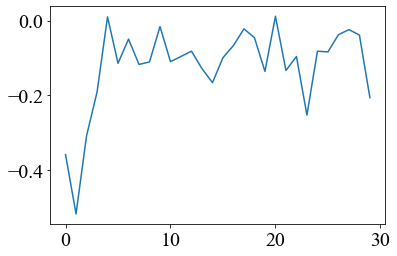

In [16]:
plt.plot(test_loss[-1])

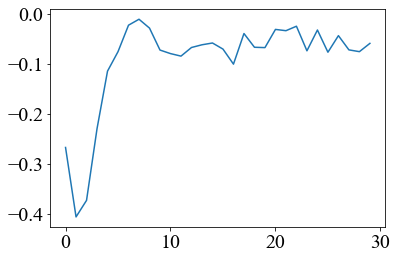

In [17]:
plt.plot(train_loss[-1])

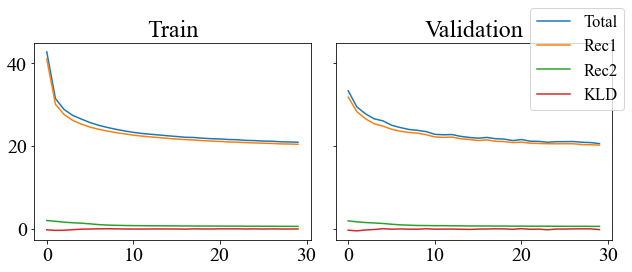

In [18]:
fig, ax = plt.subplots(ncols=2, sharex='all', sharey='all', figsize=(9, 4))

for i, label in enumerate(('Total', 'Rec1', 'Rec2', 'KLD')):
    ax[0].plot(train_loss[i], label=label)
    ax[1].plot(test_loss[i], label=label)
ax[0].set_title('Train')
ax[1].set_title('Validation')
fig.legend(*ax[0].get_legend_handles_labels(), fontsize='small')
fig.tight_layout()

In [19]:
vae, optimizer, epoch = poisevae.utils.load_checkpoint(vae, optimizer, sorted(glob.glob(PATH + 'train*.pt'))[-1])

In [20]:
epoch

30

In [21]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)])
        break

In [22]:
results['x_rec'][1].shape, data[1].shape

(torch.Size([128, 2]), torch.Size([128, 2]))

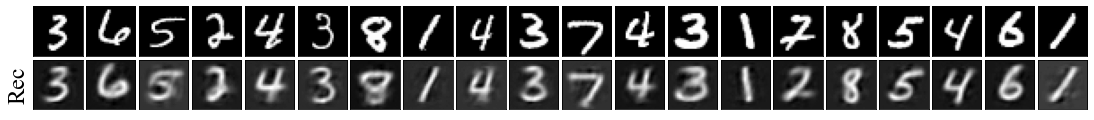

In [23]:
ncols = min(len(results['x_rec'][0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[0], results['x_rec'][0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

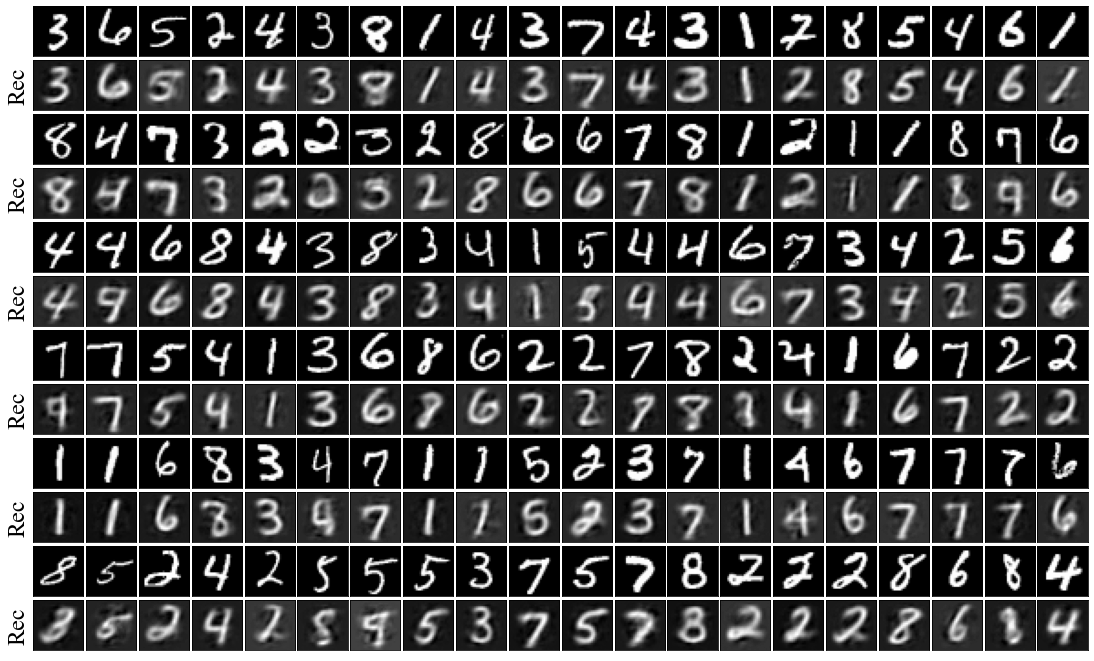

In [24]:
ncols = min(len(results['x_rec'][0]), 20)
nrows = 2 * int(np.floor(len(results['x_rec'][0]) / 20))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 1.5*nrows/2))
for i, aux in enumerate(zip(data[0], results['x_rec'][0])):
    if i >= nrows / 2 * 20:
        break
    for j, im in enumerate(aux):
        ax[j+i//20*2, i%20].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j+i//20*2, i%20].set_xticks([])
        ax[j+i//20*2, i%20].set_yticks([])
    ax[1+i//20*2, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
fig.savefig(PATH + 'MNISTRecExtra.pdf', dpi=300)

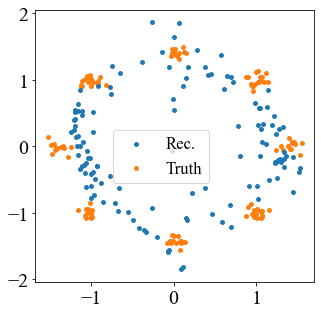

In [25]:
fig, ax = plt.subplots(1, figsize=(5, 5))
ax.scatter(*results['x_rec'][1].cpu().numpy().T, label='Rec.', s=15, zorder=3)
ax.scatter(*data[1].cpu().numpy().T, label='Truth', s=15, zorder=2)
fig.legend(fontsize='small', loc='center')
fig.savefig(PATH + 'GMRec.pdf', dpi=300)